## Assignment 4

The document is also available on [GitHub](https://github.com/taipeinative/terrain-hydrologic/blob/main/Assignment%201030/asignment-1030.ipynb).

Task 1: Implement any 3 of 8 methods introduced in the work of *Tang and Pilesjo* (2011).

Task 2: Apply the 3 methods you chose on a DEM, and then compare them with each other. Map and scatter plot are required.

Task 3: Please analyze the efficiency of the algorithm and the difference among them.

### Original DEM

The DEM used in the assignment is the fictional DEM extracted from the sim-game *Cities: Skylines II*, with the size of 4096 × 4096 pixels, the datatype of `float32`, and the resolution of 3.5 meters. Since there are no real-life counterpart for this DEM, I projected the DEM over Taipei, Taiwan (using UTM projection) for convenience.

### Method Implementation

I made a module called `sloper` that performs the slope calculations based on 7 of 8 methods (available [here](https://github.com/taipeinative/terrain-hydrologic/tree/main/Assignment%201030/sloper).) To load the data, you need to create an instance of `sloper.Dataset`. Then you can calculate the slopes by calling its method `slope(method, na_action, omit_edge, format)`.

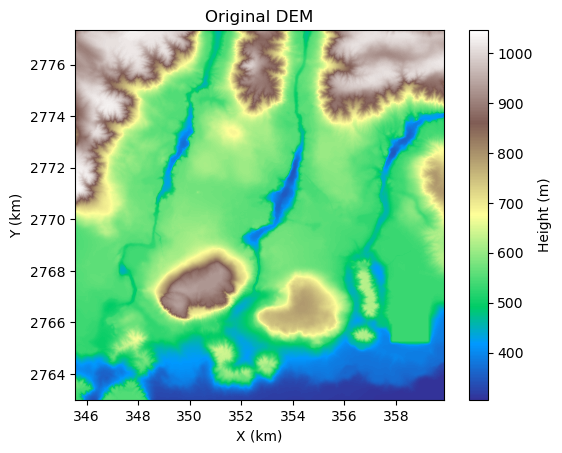

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from   scipy import ndimage
import sloper

dataset = sloper.Dataset('..\src\Sample.tif')
options = ['2FD', '3FDWRD', '3FD', '3FDWRSD', 'FFD', 'Maximum Max', 'Simple-D']

fig1, ax1 = plt.subplots()
im = ax1.imshow(dataset.z,
                extent = np.array(dataset.extent) / 1000,
                cmap = 'terrain')

cb1 = fig1.colorbar(im, ax = ax1)
cb1.set_label('Height (m)')
ax1.set(xlabel = 'X (km)', ylabel = 'Y (km)', title = 'Original DEM')

plt.show()

### Overall Assessment

The following images give a brief view of the result among different methods.

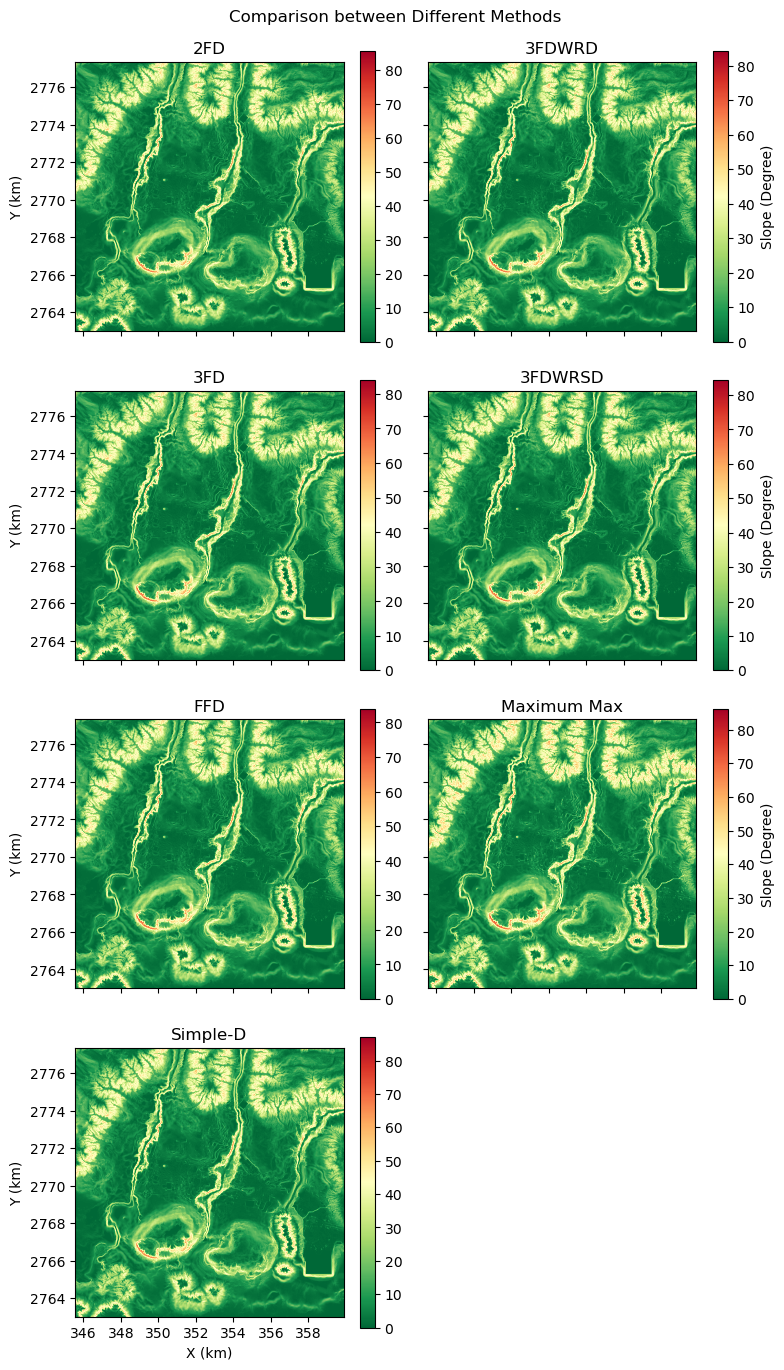

In [2]:
slope_list = []

for i in range(7):
    slope_list.append(dataset.slope(i, na_action = 'fill', format = 'degree'))

flatten_slope = [x.flatten() for x in slope_list]
bin_estimation = []

for i in range(7):
    freq, _ = np.histogram(flatten_slope[i], bins = np.arange(95, step = 5))
    bin_estimation.append(freq)

fig2, axes2 = plt.subplots(4, 2, figsize = (8, 14), sharex = True, sharey = True)
fig2.delaxes(axes2[3, 1])
axes2 = axes2.flatten()

for i in range(7):
    im = axes2[i].imshow(slope_list[i],
                         extent = np.array(dataset.extent) / 1000,
                         cmap = 'RdYlGn_r')
    cb = fig2.colorbar(im, ax = axes2[i])
    if i % 2 == 0:
        axes2[i].set(ylabel = 'Y (km)')
    else:
        cb.set_label('Slope (Degree)')

    if i in [6, 7]:
        axes2[i].set(xlabel = 'X (km)')

    axes2[i].set(title = options[i], xticks = np.arange(346, 360, 2))

fig2.tight_layout()
fig2.suptitle('Comparison between Different Methods')
fig2.subplots_adjust(top = 0.95)
plt.show()

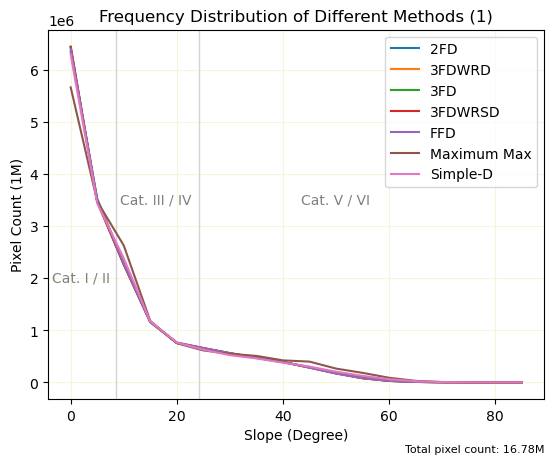

In [3]:
fig3, ax3 = plt.subplots()
bin_x = np.arange(0, 90, 5)

for i in range(7):
    ax3.plot(bin_x, bin_estimation[i], label = options[i])

for j in [8.53, 24.22]:   # Upper boundary for level 2 & 4 slopes
    ax3.axvline(j, 0, 1, zorder = 1.9, color = 'lightgrey', lw = 1)  

ax3.text(2, 2e6, 'Cat. I / II', ha = 'center', va = 'center', color = 'grey')
ax3.text(16, 3.5e6, 'Cat. III / IV', ha = 'center', va = 'center', color = 'grey')
ax3.text(50, 3.5e6, 'Cat. V / VI', ha = 'center', va = 'center', color = 'grey')

ax3.grid(color = 'beige')
ax3.set(xlabel = 'Slope (Degree)', ylabel = 'Pixel Count (1M)', title = 'Frequency Distribution of Different Methods (1)')
ax3.legend()
fig3.text(0.9, 0, 'Total pixel count: 16.78M', ha = 'right', size = 8)

plt.show()

Note: Cat. I ~ VI stands for the slope category [proposed by M.O.A., Taiwan](https://law.moj.gov.tw/LawClass/LawAll.aspx?pcode=M0110024). The category is defined as follows:

| Category | Maximum Ratio | Equivalent Degree |
| -------- | ------------: | ----------------: |
| I        |           .05 |              2.86 |
| II       |           .15 |              8.53 |
| III      |           .30 |             16.70 |
| IV       |           .40 |             24.22 |
| V        |           .55 |             28.81 |
| VI       |             ∞ |             90.00 |

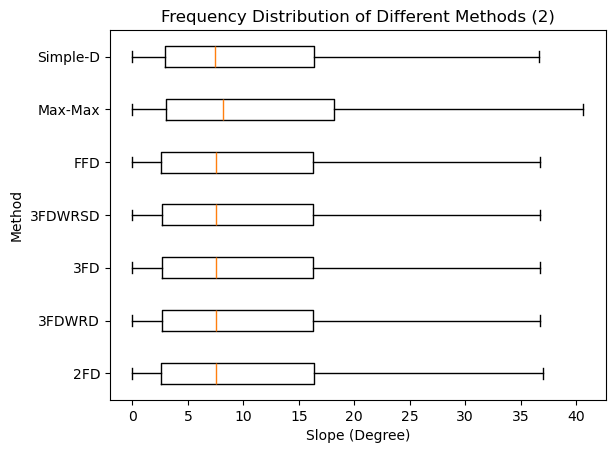

In [4]:
fix4, ax4 = plt.subplots()
ax4.boxplot(flatten_slope,
            tick_labels = ['2FD', '3FDWRD', '3FD', '3FDWRSD', 'FFD', 'Max-Max', 'Simple-D'],
            widths = 0.4,
            showfliers = False,
            vert = False)
ax4.set(xlabel = 'Slope (Degree)', ylabel = 'Method', title = 'Frequency Distribution of Different Methods (2)')

plt.show()

### Scatter plot - 2FD vs. Maximum Max vs. Simple-D

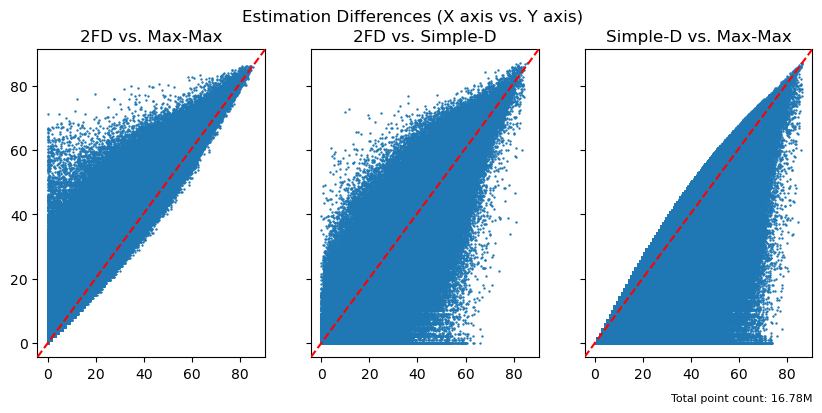

In [5]:
fig5, axes5 = plt.subplots(1, 3, figsize = (10, 4), sharex = True, sharey = True)

axes5 = axes5.flatten()

axes5[0].scatter(flatten_slope[0], flatten_slope[5], s = 0.5)
axes5[1].scatter(flatten_slope[0], flatten_slope[6], s = 0.5)
axes5[2].scatter(flatten_slope[5], flatten_slope[6], s = 0.5)

axes5[0].set(title = '2FD vs. Max-Max')
axes5[1].set(title = '2FD vs. Simple-D')
axes5[2].set(title = 'Simple-D vs. Max-Max')

for i in range(3):
    axes5[i].plot([0, 1], [0, 1], transform = axes5[i].transAxes, color = 'red', zorder = 3, ls = 'dashed')

fig5.suptitle('Estimation Differences (X axis vs. Y axis)')
fig5.text(0.9, 0, 'Total point count: 16.78M', ha = 'right', size = 8)

plt.show()

### Compare with Different Terrains

In order to test these 3 methods more in-depthly, the evaluations on both flat and hilly region are conducted. The following DEMs are cropped from the DEM used above.

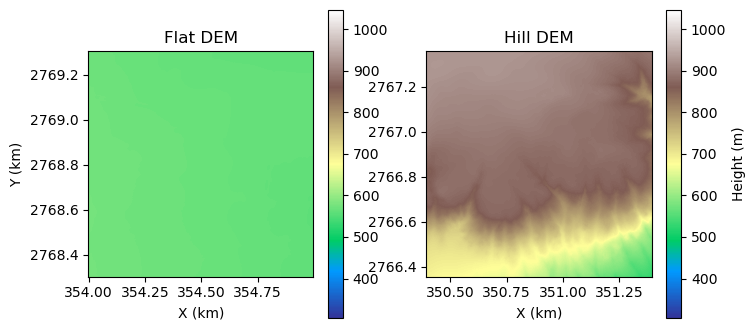

In [6]:
dataset_flat = sloper.Dataset('..\src\Sample-Flat.tif')
dataset_hill = sloper.Dataset('..\src\Sample-Hill.tif')

fig6, axes6 = plt.subplots(1, 2, figsize = (8, 4))
im1 = axes6[0].imshow(dataset_flat.z,
                         extent = np.array(dataset_flat.extent) / 1000,
                         cmap = 'terrain',
                         vmin = 305,
                         vmax = 1046)
im2 = axes6[1].imshow(dataset_hill.z,
                         extent = np.array(dataset_hill.extent) / 1000,
                         cmap = 'terrain',
                         vmin = 305,
                         vmax = 1046)

cb1 = fig6.colorbar(im1, ax = axes6[0])
cb2 = fig6.colorbar(im2, ax = axes6[1])
cb2.set_label('Height (m)')
axes6[0].set(xlabel = 'X (km)', ylabel = 'Y (km)', title = 'Flat DEM')
axes6[1].set(xlabel = 'X (km)', title = 'Hill DEM')

plt.show()

C:\Users\Daniel\AppData\Local\Temp\ipykernel_41336\3521071741.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig7.tight_layout()


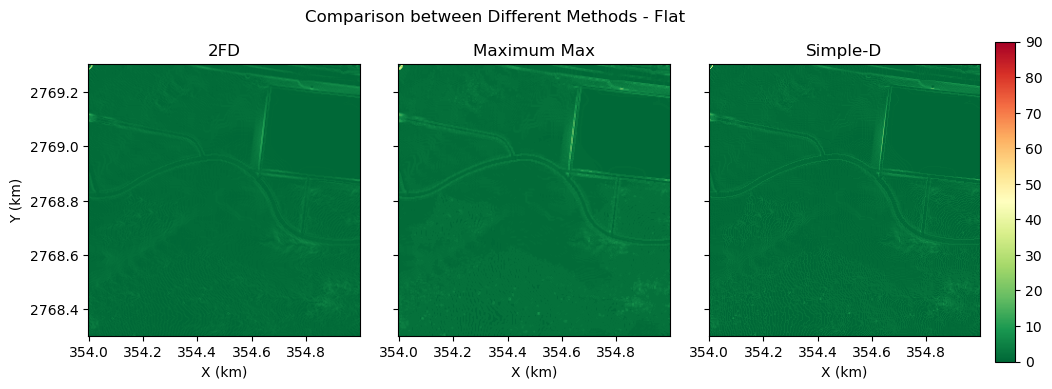

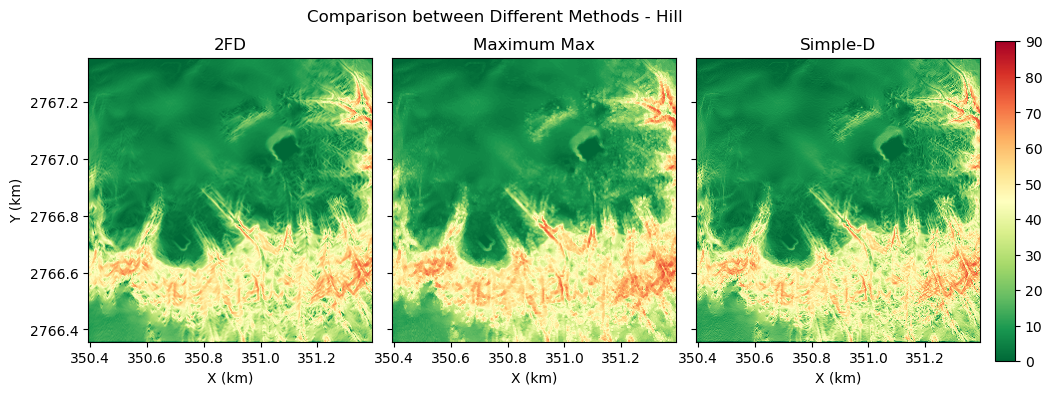

In [7]:
slope_list_flat = []
slope_list_hill = []

for i in [0, 5, 6]:
    slope_list_flat.append(dataset_flat.slope(i, na_action = 'fill', format = 'degree'))
    slope_list_hill.append(dataset_hill.slope(i, na_action = 'fill', format = 'degree'))

flatten_slope_flat = [x.flatten() for x in slope_list_flat]
flatten_slope_hill = [x.flatten() for x in slope_list_hill]
bin_estimation_flat = []
bin_estimation_hill = []

for i in range(3):
        freq, _ = np.histogram(flatten_slope_flat[i], bins = np.arange(95, step = 5))
        bin_estimation_flat.append(freq)
        freq, _ = np.histogram(flatten_slope_hill[i], bins = np.arange(95, step = 5))
        bin_estimation_hill.append(freq)

def plotA(source, extent, name):
    fig7, axes7 = plt.subplots(1, 3, figsize = (10, 4), sharey = True)

    cax = fig7.add_axes([1, 0.1, 0.02, 0.8])
    cax.spines['top'].set_visible(False)
    cax.spines['right'].set_visible(False)
    cax.spines['bottom'].set_visible(False)
    cax.spines['left'].set_visible(False)
    cax.get_xaxis().set_ticks([])
    cax.get_yaxis().set_ticks([])
    cax.patch.set_alpha(0)

    for i in range(3):
        im = axes7[i].imshow(source[i],
                             extent = np.array(extent) / 1000,
                             cmap = 'RdYlGn_r',
                             vmin = 0,
                             vmax = 90)
        
        if i == 0:
            axes7[0].set(ylabel = 'Y (km)')
        
        axes7[i].set(xlabel = 'X (km)')
        axes7[i].set(title = ['2FD', 'Maximum Max', 'Simple-D'][i])

    fig7.colorbar(im, cax = cax, orientation = 'vertical')
    fig7.tight_layout()
    fig7.suptitle(f'Comparison between Different Methods - {name}')
    plt.show()

plotA(slope_list_flat, dataset_flat.extent, 'Flat')
plotA(slope_list_hill, dataset_hill.extent, 'Hill')

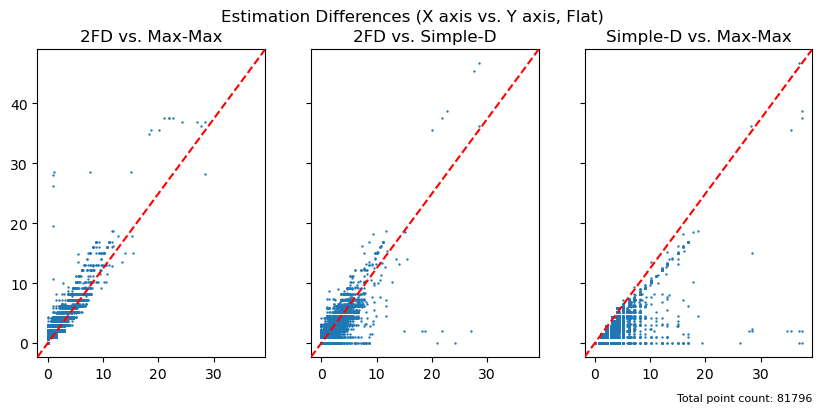

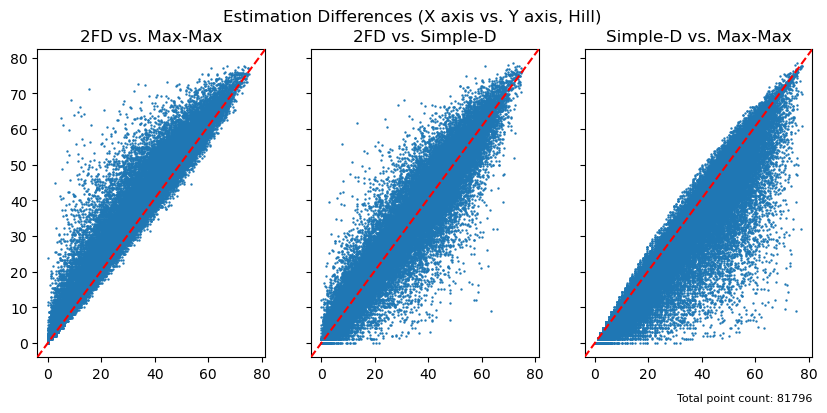

In [8]:
def plotB(source, name):
    fig8, axes8 = plt.subplots(1, 3, figsize = (10, 4), sharex = True, sharey = True)
    axes8 = axes8.flatten()
    axes8[0].scatter(source[0], source[1], s = 0.5)
    axes8[1].scatter(source[0], source[2], s = 0.5)
    axes8[2].scatter(source[1], source[2], s = 0.5)

    axes8[0].set(title = '2FD vs. Max-Max')
    axes8[1].set(title = '2FD vs. Simple-D')
    axes8[2].set(title = 'Simple-D vs. Max-Max')

    for i in range(3):
        axes8[i].plot([0, 1], [0, 1], transform = axes8[i].transAxes, color = 'red', zorder = 3, ls = 'dashed')

    fig8.suptitle(f'Estimation Differences (X axis vs. Y axis, {name})')
    fig8.text(0.9, 0, 'Total point count: 81796', ha = 'right', size = 8)

    plt.show()

plotB(flatten_slope_flat, 'Flat')
plotB(flatten_slope_hill, 'Hill')

### Conclusion

The overall execution time is about the same for the last two algorithm, and a bit longer for Maximum Max. The algorithm Maximum Max is the most 'sensitive' among 3 algorithms, since it always take the steepest slope from 8 possible options. The two remaining algorithms are really close to each other - the only difference is that Simple-D take the differences from the center to the south & east, while 2FD take the difference from north to south and west to east.

### Appendix - Fill NaNs

The following script shows the procedure to remove and estimate height values of NaNs in the DEM. The implementation was done in `sloper.Utils.fill_nan()`.

In [9]:
def fill_nan_demo():
    dem = np.array([[0, 1, 5, 2], [np.nan, 3, 4, np.nan], [np.nan, np.nan, 2, 3], [np.nan ,np.nan, 1, 4]])
    new_dem = dem.copy()
    print('Original DEM:')
    print(dem, end = '\n\n')

    win = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]])

    non_nan_neighbor = ndimage.convolve(1 - np.isnan(dem).astype(int), win, mode = 'constant')
    print('Neighbor non-NaN counts:')
    print(non_nan_neighbor, end = '\n\n')

    summation = ndimage.convolve(np.nan_to_num(dem), win, mode = 'constant')
    print('Neighbor summation:')
    print(summation, end = '\n\n')

    valid_mask = np.isnan(dem) & (non_nan_neighbor > 1)
    print('Valid mask:')
    print(valid_mask, end = '\n\n')

    with np.errstate(divide = 'ignore', invalid = 'ignore'):
        # Ignore divide by 0 and nan warnings
        np.putmask(new_dem, valid_mask, summation / non_nan_neighbor)
    print('New DEM:')
    print(new_dem, end = '\n\n')

    print('New DEM generated by `sloper.Utils.fill_nan()`')
    print(sloper.Utils.fill_nan(dem))

fill_nan_demo()

Original DEM:
[[ 0.  1.  5.  2.]
 [nan  3.  4. nan]
 [nan nan  2.  3.]
 [nan nan  1.  4.]]

Neighbor non-NaN counts:
[[2 4 4 2]
 [3 5 6 5]
 [1 4 5 4]
 [0 2 3 3]]

Neighbor summation:
[[ 4. 12. 10.  9.]
 [ 4. 12. 16. 16.]
 [ 3. 10. 15. 11.]
 [ 0.  3.  9.  6.]]

Valid mask:
[[False False False False]
 [ True False False  True]
 [False  True False False]
 [False  True False False]]

New DEM:
[[0.         1.         5.         2.        ]
 [1.33333333 3.         4.         3.2       ]
 [       nan 2.5        2.         3.        ]
 [       nan 1.5        1.         4.        ]]

New DEM generated by `sloper.Utils.fill_nan()`
[[0.         1.         5.         2.        ]
 [1.33333333 3.         4.         3.2       ]
 [2.08333333 2.5        2.         3.        ]
 [2.         1.5        1.         4.        ]]
